# PRIMERA PARTE DEL EDA

## Primera exploracion de los datos

In [1]:
 # Librerias 
%run imports.py 
from funciones import *
from Recursos.monitor_resources import *

1) Cargado del fichero inicial

In [2]:
photos = pd.read_json("photos.json", lines=True)
photos.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [3]:
# Skim output 
skim(photos)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 200100 │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 4      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ photo_id                  │       0 │          0 │                            1 │                   200100 │  │
│ │ business_id               │       0 │          0 │                            1 │                   200100 │  │
│ │ caption                   │       0 │          0 │                            3 │                   610159 │  │
│ │ label                     │       0 │          0 │                            1 │                   200100 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

2) Distribucion de muestras por "label" del conjunto de datos completo (incluye imagenes corruptas)

In [4]:
# Muestras de cada tipo de fotografia 
photos["label"].value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

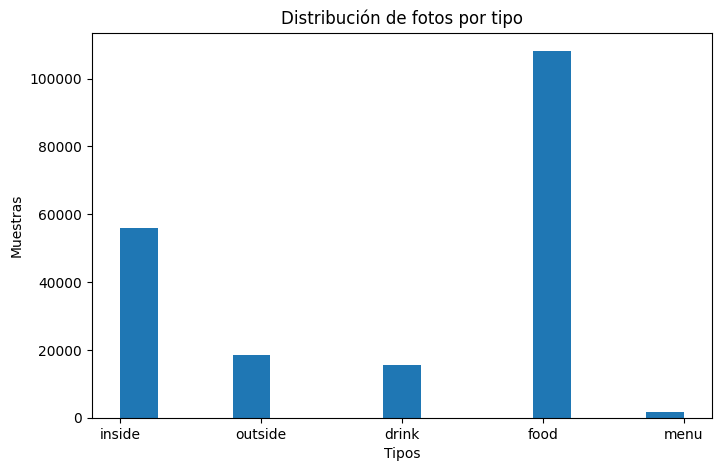

In [5]:
# Plot de distribucion 
plt.figure(figsize=(8,5))
plt.title("Distribución de fotos por tipo")
plt.hist(x = photos["label"], bins=15)
plt.xlabel("Tipos")
plt.ylabel("Muestras")
plt.show()

In [6]:
# output counter  
print(f'{counter("output/valid_photos.json")}')
print(f'{counter("photos.json")}')


190006 items
200100 items


## Eliminacion de las imagenes corruptas

In [7]:
# depuracion de la carpeta fotos para filtrar las fotos con formato adecuado

imagenes_validas = valid("photos")

Procesando Imagenes:   1%|          | 1990/192342 [00:01<01:56, 1630.24it/s]

Error al procesar la imagen 2S78q98b_VpBD7vkrDE5-A.jpg


Procesando Imagenes:   3%|▎         | 6187/192342 [00:03<01:41, 1829.02it/s]

Error al procesar la imagen 43fHlHSYQ_79OBJW1aVUxA.jpg


Procesando Imagenes:   6%|▌         | 11199/192342 [00:06<01:39, 1819.09it/s]

Error al procesar la imagen 5q-sAvIPl0yNeuAbNBPM1g.jpg


Procesando Imagenes:   7%|▋         | 12688/192342 [00:07<01:38, 1818.53it/s]

Error al procesar la imagen 6bKuH4FOdaaPInF9NmlQHQ.jpg


Procesando Imagenes:   8%|▊         | 15552/192342 [00:08<01:31, 1924.29it/s]

Error al procesar la imagen 74upe0h6XxwgzqpdnAh_7Q.jpg


Procesando Imagenes:   9%|▉         | 18052/192342 [00:09<01:31, 1896.21it/s]

Error al procesar la imagen 7xcWPjcE4mxoQ1AjvvKJZg.jpg


Procesando Imagenes:  12%|█▏        | 22285/192342 [00:12<01:29, 1894.33it/s]

Error al procesar la imagen 9BvYOtforBBP6MvvDogtmw.jpg


Procesando Imagenes:  12%|█▏        | 23056/192342 [00:12<01:28, 1922.18it/s]

Error al procesar la imagen 9jBH61ndIcsheo6FtIHArA.jpg


Procesando Imagenes:  12%|█▏        | 23830/192342 [00:12<01:28, 1906.54it/s]

Error al procesar la imagen 9RDbbAZB0HnL4hndCWB58w.jpg


Procesando Imagenes:  13%|█▎        | 24212/192342 [00:13<01:28, 1902.41it/s]

Error al procesar la imagen 9X4YPM8nYFjf7hY8xUdc6Q.jpg


Procesando Imagenes:  14%|█▍        | 27692/192342 [00:14<01:25, 1924.48it/s]

Error al procesar la imagen AkiGRjaMKHdJyV7bdHsQjw.jpg


Procesando Imagenes:  15%|█▍        | 28078/192342 [00:15<01:25, 1917.30it/s]

Error al procesar la imagen amM65inTV6wvx0NNZN5qhg.jpg
Error al procesar la imagen AMSyCOP3-Eb_ivNA8w1Vhw.jpg


Procesando Imagenes:  15%|█▌        | 29240/192342 [00:15<01:25, 1916.99it/s]

Error al procesar la imagen ARwqGQZaT0p-XpYYjMXgQg.jpg


Procesando Imagenes:  15%|█▌        | 29652/192342 [00:15<01:21, 1997.69it/s]

Error al procesar la imagen aUDiJhcFKt0exhyj4Q23Ow.jpg


Procesando Imagenes:  18%|█▊        | 34105/192342 [00:18<01:21, 1947.07it/s]

Error al procesar la imagen B7xR9CuhRpP52PoehQHVow.jpg


Procesando Imagenes:  18%|█▊        | 35265/192342 [00:18<01:23, 1891.72it/s]

Error al procesar la imagen bf3ymV0YgP7B6rEoriaU2w.jpg


Procesando Imagenes:  21%|██        | 40088/192342 [00:21<01:19, 1920.84it/s]

Error al procesar la imagen C6n0nKVbgLbYmxSiQ_bFsg.jpg
Error al procesar la imagen c73YwNh1JsYR5Hz-u_bOrg.jpg
Error al procesar la imagen CA9z96gGA4y9QOes2Y9eGw.jpg


Procesando Imagenes:  21%|██        | 40862/192342 [00:21<01:18, 1929.25it/s]

Error al procesar la imagen CBxmBYD_5CXIL_F-2PDqmA.jpg


Procesando Imagenes:  22%|██▏       | 42998/192342 [00:22<01:17, 1923.17it/s]

Error al procesar la imagen cNkUV0sInfh_Py5PP8SHtQ.jpg


Procesando Imagenes:  23%|██▎       | 44938/192342 [00:23<01:16, 1929.91it/s]

Error al procesar la imagen cwwoZcpqdu2MwdDusNyTdg.jpg


Procesando Imagenes:  24%|██▍       | 46872/192342 [00:24<01:15, 1937.64it/s]

Error al procesar la imagen DB7BlUpO4LAmC1lCN62hqg.jpg


Procesando Imagenes:  26%|██▌       | 49202/192342 [00:26<01:14, 1923.15it/s]

Error al procesar la imagen DMCTwC3UT2w5QzHOQoqBPw.jpg


Procesando Imagenes:  27%|██▋       | 52405/192342 [00:29<05:19, 438.20it/s] 

Error al procesar la imagen E7Wpzn-1fCnVJ8_zKpecPQ.jpg


Procesando Imagenes:  31%|███       | 59832/192342 [00:47<05:12, 423.54it/s]

Error al procesar la imagen feUGw0P5byOq4U40C77tyQ.jpg


Procesando Imagenes:  35%|███▍      | 66937/192342 [01:03<04:50, 431.35it/s]

Error al procesar la imagen gJH0d6Sut4eZDlbV0GCByg.jpg


Procesando Imagenes:  35%|███▌      | 68143/192342 [01:06<04:42, 439.82it/s]

Error al procesar la imagen GPMWGVjuCsa6fadnZsEplw.jpg


Procesando Imagenes:  36%|███▌      | 69488/192342 [01:09<04:33, 449.59it/s]

Error al procesar la imagen GWLmPwKeBnh2b_7Kv_LQ7w.jpg


Procesando Imagenes:  37%|███▋      | 71740/192342 [01:14<04:29, 447.34it/s]

Error al procesar la imagen hChXG-gGWxzGvalse3EYmw.jpg
Error al procesar la imagen hclqCX1FWcV_TtJJoI3BpQ.jpg


Procesando Imagenes:  38%|███▊      | 73098/192342 [01:17<04:47, 414.92it/s]

Error al procesar la imagen hjEfal2a1DWRDu8_AUDLNg.jpg


Procesando Imagenes:  40%|████      | 77751/192342 [01:28<04:13, 451.70it/s]

Error al procesar la imagen IB2ZjqjtS1W_DadQoPPdgg.jpg


Procesando Imagenes:  41%|████      | 78515/192342 [01:29<04:15, 445.02it/s]

Error al procesar la imagen IExxMfr1h0bxw54jsanyKA.jpg


Procesando Imagenes:  41%|████▏     | 79565/192342 [01:32<04:18, 437.00it/s]

Error al procesar la imagen IkGbGxI8IoOCuVsNB0VLrA.jpg


Procesando Imagenes:  42%|████▏     | 81592/192342 [01:36<04:05, 451.11it/s]

Error al procesar la imagen IUsKp87a-v9Yhx6Ftg1m5A.jpg


Procesando Imagenes:  43%|████▎     | 82048/192342 [01:37<04:04, 450.67it/s]

Error al procesar la imagen iX-8Xm2G7meRHUg8qhoL1A.jpg


Procesando Imagenes:  43%|████▎     | 83353/192342 [01:40<04:09, 436.82it/s]

Error al procesar la imagen j5-4lzg23yGECBa6l1fyRQ.jpg


Procesando Imagenes:  44%|████▍     | 85075/192342 [01:44<03:57, 451.29it/s]

Error al procesar la imagen JG5s_bvRF1cSWf1fk9lTbw.jpg


Procesando Imagenes:  44%|████▍     | 85211/192342 [01:45<04:02, 442.47it/s]

Error al procesar la imagen JGpfPj8VEvnq1B-Xqr3w-A.jpg


Procesando Imagenes:  45%|████▌     | 86712/192342 [01:48<03:54, 450.63it/s]

Error al procesar la imagen JoQ5xekjQUkj8rukJIzqgg.jpg


Procesando Imagenes:  46%|████▌     | 87802/192342 [01:51<03:51, 452.33it/s]

Error al procesar la imagen jU-dKl2Ye4L_5x602yoctQ.jpg
Error al procesar la imagen juDNZOOnkgG3QINFrulsAg.jpg


Procesando Imagenes:  46%|████▋     | 89004/192342 [01:53<03:58, 433.38it/s]

Error al procesar la imagen JZZ716oX6_MqH6L_MkWK-A.jpg


Procesando Imagenes:  47%|████▋     | 89849/192342 [01:55<04:03, 420.07it/s]

Error al procesar la imagen K6pfRNwGodm1m1gFVQlj-Q.jpg


Procesando Imagenes:  47%|████▋     | 90927/192342 [01:58<03:47, 445.49it/s]

Error al procesar la imagen ke4ohxa93GJz0KH9H2kwsQ.jpg


Procesando Imagenes:  48%|████▊     | 91926/192342 [02:00<03:43, 448.46it/s]

Error al procesar la imagen kjMBhxBXOUE7SSUQb-YQbw.jpg


Procesando Imagenes:  50%|████▉     | 95570/192342 [02:08<03:40, 439.08it/s]

Error al procesar la imagen l2vR3PyVMF3pgIERdDEuiQ.jpg


Procesando Imagenes:  51%|█████     | 97873/192342 [02:14<03:50, 409.47it/s]

Error al procesar la imagen LhLfsQtYwJ5OmEzilubhXQ.jpg


Procesando Imagenes:  52%|█████▏    | 99869/192342 [02:18<03:27, 445.65it/s]

Error al procesar la imagen lrfy4UVIWtj0xwboLgUreQ.jpg


Procesando Imagenes:  53%|█████▎    | 101054/192342 [02:21<03:24, 446.09it/s]

Error al procesar la imagen LXT4hCf1lRyUeM4HDBaSvg.jpg


Procesando Imagenes:  53%|█████▎    | 101592/192342 [02:22<03:34, 423.68it/s]

Error al procesar la imagen l_rMdwgrvjm2PyHyXBcBTw.jpg


Procesando Imagenes:  53%|█████▎    | 102048/192342 [02:23<03:18, 454.62it/s]

Error al procesar la imagen m3oIKhKKCQD54y1E-dBKSw.jpg


Procesando Imagenes:  54%|█████▍    | 103479/192342 [02:26<03:23, 437.61it/s]

Error al procesar la imagen MduVueqYTBlEkX-axrh1ug.jpg


Procesando Imagenes:  56%|█████▌    | 107726/192342 [02:36<03:25, 411.53it/s]

Error al procesar la imagen MZj64XNUN6Og178-6XYR6g.jpg


Procesando Imagenes:  56%|█████▋    | 108673/192342 [02:38<03:05, 450.50it/s]

Error al procesar la imagen N6hL8FQ84A2DznF2S2Lp7g.jpg
Error al procesar la imagen n6Q9vNuxz7786ESEfautxQ.jpg


Procesando Imagenes:  57%|█████▋    | 110093/192342 [02:41<03:08, 436.34it/s]

Error al procesar la imagen NfayhoTudVJQsEF-XlPyjw.jpg


Procesando Imagenes:  58%|█████▊    | 111034/192342 [02:44<03:01, 448.81it/s]

Error al procesar la imagen NKEFWvRriK-LvagPz2QRxw.jpg
Error al procesar la imagen nKJ7yiPc0E_DJNtNxmCrhg.jpg


Procesando Imagenes:  59%|█████▉    | 114428/192342 [02:51<02:53, 449.60it/s]

Error al procesar la imagen O0bVFyP58TOEix6IjERXQA.jpg


Procesando Imagenes:  61%|██████    | 117283/192342 [02:58<02:46, 449.57it/s]

Error al procesar la imagen OK6HsALzFcBAUlrroKHZGg.jpg


Procesando Imagenes:  64%|██████▎   | 122557/192342 [03:10<02:53, 403.29it/s]

Error al procesar la imagen PFD3ykdI1WVhvZ8IX4PmLQ.jpg


Procesando Imagenes:  64%|██████▍   | 123369/192342 [03:11<02:35, 444.43it/s]

Error al procesar la imagen PjfJoBrEFgDrxiJy8nyatA.jpg


Procesando Imagenes:  64%|██████▍   | 123504/192342 [03:12<02:35, 441.59it/s]

Error al procesar la imagen Pk87_8Yndygr4LRUD_H7Hg.jpg


Procesando Imagenes:  65%|██████▌   | 125843/192342 [03:17<02:27, 451.04it/s]

Error al procesar la imagen pW1IPuTdLIUB61goirbXaA.jpg


Procesando Imagenes:  66%|██████▌   | 126246/192342 [03:18<02:29, 443.16it/s]

Error al procesar la imagen pY32hIagdxrL4Nsi959EQg.jpg


Procesando Imagenes:  67%|██████▋   | 129295/192342 [03:25<02:20, 448.74it/s]

Error al procesar la imagen QhATx1B1n8uf8C6siMNTfA.jpg


Procesando Imagenes:  68%|██████▊   | 130439/192342 [03:27<02:18, 447.05it/s]

Error al procesar la imagen qMlGILrsrzhMDxajNYiyIA.jpg


Procesando Imagenes:  68%|██████▊   | 131445/192342 [03:30<02:16, 445.54it/s]

Error al procesar la imagen QRUo4vqUu3X9V4eIqBpY8A.jpg


Procesando Imagenes:  69%|██████▉   | 132626/192342 [03:32<02:36, 381.10it/s]

Error al procesar la imagen qxSXsYMA3aWuAfigeqeOOQ.jpg


Procesando Imagenes:  70%|███████   | 135576/192342 [03:39<02:05, 453.93it/s]

Error al procesar la imagen RhC7TNmFvbR9GWrlrl5dsA.jpg


Procesando Imagenes:  71%|███████   | 135804/192342 [03:40<02:06, 447.29it/s]

Error al procesar la imagen RIeulJUzgemFugkkgg4qgA.jpg
Error al procesar la imagen rIhUkEmP-j4NcQVW3YuPYQ.jpg


Procesando Imagenes:  71%|███████   | 136390/192342 [03:41<02:05, 444.89it/s]

Error al procesar la imagen rLafN9k3_AF5lZU0cs3LZg.jpg


Procesando Imagenes:  71%|███████   | 136480/192342 [03:41<02:09, 432.60it/s]

Error al procesar la imagen RLtBKD2rlfTaELWejmLBCA.jpg


Procesando Imagenes:  72%|███████▏  | 137558/192342 [03:44<02:06, 434.42it/s]

Error al procesar la imagen rrfwGSwt3eHxxypfu5PGTA.jpg


Procesando Imagenes:  77%|███████▋  | 149058/192342 [04:10<01:36, 446.40it/s]

Error al procesar la imagen tlp6LCLDsvL1GjO_kW_plQ.jpg


Procesando Imagenes:  78%|███████▊  | 149333/192342 [04:10<01:34, 452.92it/s]

Error al procesar la imagen TN4-gAea6ejAdZ-NzYXxng.jpg


Procesando Imagenes:  78%|███████▊  | 150417/192342 [04:13<01:31, 456.44it/s]

Error al procesar la imagen tSHz7RzlgceAItRejZ396A.jpg


Procesando Imagenes:  78%|███████▊  | 150921/192342 [04:14<01:31, 451.65it/s]

Error al procesar la imagen TvD36_DdnyCJuXV1SSt3_Q.jpg


Procesando Imagenes:  79%|███████▉  | 151926/192342 [04:16<01:32, 435.44it/s]

Error al procesar la imagen t_sV6mI4oNvbvohhZAyeuA.jpg


Procesando Imagenes:  80%|████████  | 154207/192342 [04:21<01:25, 448.39it/s]

Error al procesar la imagen UG2JuFFa_WxhPEtMOtq-JQ.jpg


Procesando Imagenes:  85%|████████▍ | 162644/192342 [04:40<01:05, 453.90it/s]

Error al procesar la imagen VSekUmmsGZcX7KaPe_hXyw.jpg


Procesando Imagenes:  86%|████████▌ | 164919/192342 [04:46<01:00, 453.34it/s]

Error al procesar la imagen w5ABnSadHC8z1lthMQBaBQ.jpg


Procesando Imagenes:  86%|████████▌ | 165281/192342 [04:46<01:01, 443.58it/s]

Error al procesar la imagen W94rrCn0O5K1lkfD26m4tw.jpg


Procesando Imagenes:  87%|████████▋ | 166656/192342 [04:49<00:55, 458.89it/s]

Error al procesar la imagen WGmGujPl5BmR_fCUZnoe9w.jpg


Procesando Imagenes:  92%|█████████▏| 176043/192342 [05:11<00:36, 449.76it/s]

Error al procesar la imagen XX6ujA9CcB5s9y9wCy67-Q.jpg


Procesando Imagenes:  92%|█████████▏| 177104/192342 [05:13<00:39, 389.73it/s]

Error al procesar la imagen Y3lA41pnMkQNGfyREkf6SA.jpg


Procesando Imagenes:  92%|█████████▏| 177771/192342 [05:15<00:32, 447.48it/s]

Error al procesar la imagen yAf6R6OSgPo8-mmdDh8qIw.jpg


Procesando Imagenes:  93%|█████████▎| 178457/192342 [05:16<00:31, 446.60it/s]

Error al procesar la imagen ydm3g1wUWSxJnMPgHk2JhQ.jpg


Procesando Imagenes:  93%|█████████▎| 178768/192342 [05:17<00:30, 439.00it/s]

Error al procesar la imagen yFjqHyOaNFwzIWTV8EE9hg.jpg


Procesando Imagenes:  93%|█████████▎| 179312/192342 [05:19<00:34, 380.69it/s]

Error al procesar la imagen yhztPWh5IhaePpUQJNW-dQ.jpg


Procesando Imagenes:  94%|█████████▍| 181533/192342 [05:24<00:24, 437.47it/s]

Error al procesar la imagen ytJ4lihJrvyzMMRG-WwDNw.jpg


Procesando Imagenes:  95%|█████████▍| 182069/192342 [05:25<00:23, 435.18it/s]

Error al procesar la imagen YW1WMOkVbdFBrixDnKgoqA.jpg


Procesando Imagenes:  98%|█████████▊| 187940/192342 [05:39<00:09, 451.55it/s]

Error al procesar la imagen zTzdu2QqLozHpW_qYWF84w.jpg


Procesando Imagenes:  99%|█████████▉| 190274/192342 [05:44<00:04, 440.24it/s]

Error al procesar la imagen _exWW0g4Svg1Eo2YWsGzbg.jpg


Procesando Imagenes: 100%|██████████| 192342/192342 [05:49<00:00, 550.73it/s]


Creamos un nuevo json que contenga exclusivamente las imagenes de formato correcto

In [ ]:
# creacion de valid_photos.json
with open("output/valid_photos.json", "w") as output_doc: 
    json.dump(imagenes_validas, output_doc, indent=4)

Una vez que tenemos el json con las imagenes validas podemos volcarlo como filtro en el dataset origen para obtener un dataset sobre el que trabajar


In [ ]:
# Dataset completo filtrado 
with open("output/valid_photos.json") as output_doc: 

    jpg_ids = json.load(output_doc)
    valid_ids = [id_name.replace(".jpg","") for id_name in jpg_ids ]

    valid_photos = photos[photos["photo_id"].isin(valid_ids)]

valid_photos.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


Convierto el dataset de fotos validas en un csv para tenerlo de base de datos (por si acaso)

In [ ]:
# Creacion de valid_photos.csv
valid_photos.to_csv("output/valid_photos.csv", index= False)

## Homogeinizacion de muestras (Downsampling)
 

En este paso el código acota el dataset al mínimo numero de muestras ( ~1600 ) 

In [ ]:
sample_size = valid_photos[valid_photos["label"] == "menu"].shape[0] # Numero de muestras que queremos para todas las etiquetas 
labels = set(valid_photos["label"].unique())  # Etiquetas de las fotos
sample_list = [] # Guardado 


for label in labels: 
    label_samples = valid_photos[valid_photos["label"] == label]["photo_id"].sample(n=sample_size, random_state= 42)
    sample_list.append(label_samples) 


En sample_list, se recoge un total de 5 listas diferentes con las muestras homogeneizadas de cada "label". Para comprobarlo, simplemente muestro la longitud de cada elemento de la lista ( que es tambien una lista) para ver que todas tienen la misma dimension

In [ ]:
# muestras reducidas 
for _ in sample_list: 
    print(len(_))  # comprobacion de que esta bien 

1593
1593
1593
1593
1593


In [ ]:
# Agrupamos las listas en una ( numero de elementos la suma de las 5 ) == 7965
all_samples = pd.concat(sample_list) 

print(f"Numero de muestras homogeneizadas: {len(all_samples)}")

Numero de muestras homogeneizadas: 7965


Guardo todo (again) todo en un csv 

In [ ]:
model_photos_v1= valid_photos[valid_photos["photo_id"].isin(all_samples)] # filtramos el dataset limpio de imagenes corruptas con las muestras escogidas

# guardamos en un csv el prototipo de muestra que podria ser para modelizar
model_photos_v1.to_csv("output/model_photosv1.0.csv", index = False)

## Comentarios 

1)  Data set con pocas muestras -> No seria mala Data Augmentation (en Keras o Tensorflow e.j )
2)  Estudiar la resolucion de las imagenes para ver si hay muchas de un tipo o si hace falta introducir resoluciones variadas (¿librerias para cambiar la resolución??) -> De cara a lo que nos dijo Pelayo acerca de la precisión en la detección de las imageness : "Entrenar con mucha resolución puede jugar en nuestra contra a la hora de modelar".
3) Research de modelos -> pendiente ( Mirar documentacion de Pelayo)